In [2]:
%matplotlib inline
import numpy as np
import pylab as pl
import sympy as sym
from sympy.functions import Abs
#from sympy import Abs, Symbol, S

## Goals of today:

- Check how good or bad are the estimates given in the theoretical lecture
- Compare Equispaced with Chebyshev
- Compute errors, plot error tables
- Implement Bernstein interpolation
- Compare Bernstein interpolation with Lagrangian interpolation

## Lagrangian part

The estimate we want to check:

$$
|| f -p || \leq ||f^{n+1}||_\infty \frac{||w(x)||_\infty}{(n+1)!}
$$

in order to do so we need to define, simbolic and numerical functions. [`Sympy`]() is a very useful package to handle symbolic expressions and to export them to numerical functions. A the beginnnig of this notebook it is imported with the command: `import sympy as sym`. Let's define a simple function:

**Hint:** Try to play around, derivatives integrals...

In [58]:
x = np.linspace(-5,5,2**10+1)

f = lambda x: 1.0/(1.0+x**2)  # Runge function

y = f(x)

# _ = pl.plot(x,y)

l_infty_2 = lambda y: np.linalg.norm(y, ord=np.inf)

def l_infty_1(y):
    m = -1
    for yi in y:
        m = max(m,abs(yi))
    return m

l_infty = lambda y: abs(y).max()

yy = np.random.rand(int(1e6))
# %timeit l_infty(yy)
# %timeit l_infty_1(yy)
# %timeit l_infty_2(yy)

In [68]:
# Constructing symbolic functions
t = sym.var("t")
fs = 1.0/(1.0+t**2)
dfs = fs.diff(t,1)


To make this function *digestible* by numpy we use the simple command `nf = sym.lambdify(t,f, 'numpy')`. This allows the function nf to be called with numpy arguments.

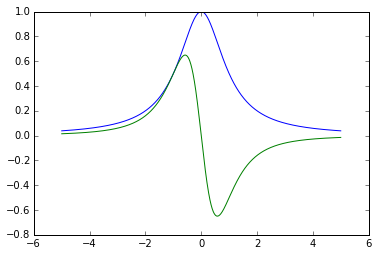

In [49]:
nf = sym.lambdify(t,fs,'numpy')
nf_prime = sym.lambdify(t,fs,'numpy')
_ = pl.plot(x,nf(x))
_ = pl.plot(x,nf_prime(x))

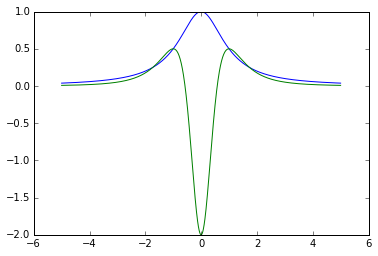

In [56]:
# def my_derivatives(f,n,t=t):
#     return sym.lambdify(t,f.diff(t,n),'numpy')

my_derivatives = lambda f,n : sym.lambdify(t,f.diff(t,n),'numpy')

fpp = my_derivatives(fs,2)

_ = pl.plot(x,f(x))
_ = pl.plot(x, fpp(x))

In [71]:
# Check for two functions
function_set = [ fs, sym.sin(t) ] 

for myf in function_set:
    print('*******\n',myf)
    for i in range(20):
        print( l_infty( my_derivatives(myf,i)(x)) )

*******
 1.0/(t**2 + 1.0)
1.0
0.649517020733
2.0
4.66826090562
24.0
100.432391447
720.0
4391.25996593
40320.0
324128.780496
3628800.0
36244225.0686
479001600.0
5731309574.55
87178291200.0
1.2122585558e+12
2.0922789888e+13
3.32025197014e+14
6.40237370573e+15
1.14456225176e+17
*******
 sin(t)
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0
0.999998920582
1.0


We aim at controlling all of the pieces of the inequality above, plot how terms behave with the degree, and see what happens `:)`

Good thing is to start from the beginning and control the term $||f-p||_\infty$. We recall that:
$$
p = \mathcal{L}^n f := \sum_{i=0}^n f(x_i) l^n_i(x),
$$

with

$$
l^n_i(x) := \prod_{j=0, j\neq i}^n \frac{(x-x_j)}{(x_i-x_j)}  \qquad
i = 0, \dots, n.
$$

Let's implment this guy. We want to fill the matrix `Ln` with $n+1$ rows and as many colums as the number of points where we evaluate the funtion. A good idea would be to collect the few operations in a function, like this one:
```python
def lagrangian_interpolation_matrix(x,q):
    ...
    return Ln
```
so that we can recall it whenever we need it.

**Hint:** I wouldn't call myself a good programmer, but I do my best to be like that. First construct the code in the main section of your program, run it, check that it works, then collect the precious commmands you wrote in an function.

### Step 0

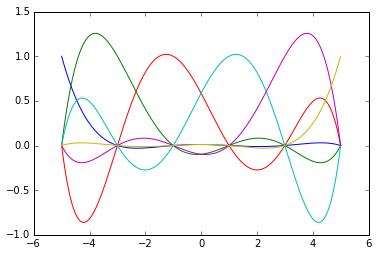

In [103]:
n = 5
q = np.linspace(-5,5,n+1)
x = np.linspace(-5,5,2**10+1)

def lagrange_interpolation(x,q):
    Ln = np.zeros((n+1,len(x)))
    for i in range(n+1):
        Ln[i] = np.prod( [ (x-q[j])/(q[i]-q[j]) for j in range(n+1) if j!=i ],axis=0)
    return Ln
Ln = lagrange_interpolation(x,q)
    
_ = pl.plot(x, Ln.T)

## Step 1

Now we transform this into a function that takes the points where we want to compute the 
matrix, and the interpolation points we use to define the basis.

In [104]:
def lagrangian_interpolation_matrix(x,q):
#     n = len(q)
    Ln = np.zeros((len(q),len(x)))
    for i in range(len(q)):
        Ln[i] = np.prod( [ (x-q[j])/(q[i]-q[j]) for j in range(n+1) if j!=i ],axis=0)
    return Ln

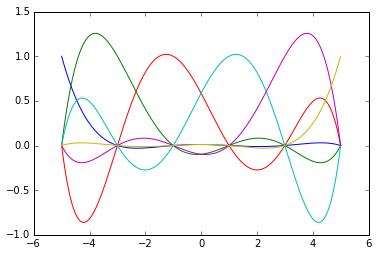

In [108]:
Ln = lagrangian_interpolation_matrix(x,q)
    
_ = pl.plot(x, Ln.T)

From the previous lecture we know that the mathemathical expression:
$$
(\mathcal{L}^nf)(x_i) := \sum_{j=0}^n f(q_j) l^n_j(x_i) = (\text{Ln}^T f)_i
$$

Can be easyly translated into the `numpy` line:
```python
Ln.T.dot(f(x))
```
Let's give it a try:


In [166]:
n = 500

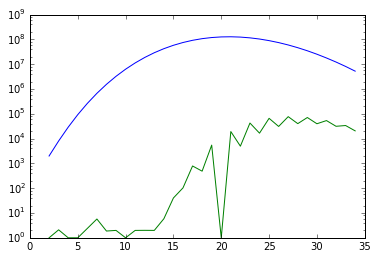

In [170]:
# f = lambda x: np.sin(2*np.pi*x)
fs = sym.sin(2*sym.pi*t)

UpperEstimate = []
error = []
points = np.arange(2,35)
f = sym.lambdify(t,fs,'numpy')
for n in points:
    
    q = np.linspace(-5,5,n+1)
    x = np.linspace(-5,5,2**10+1)
    Ln = lagrangian_interpolation_matrix(x,q)

    error.append(l_infty(f(x) - Ln.T.dot(f(q))))

    fp = my_derivatives(fs, len(q))

    nth_der = l_infty(fp(x))
    w_infty = l_infty(w(x,q))

    UpperEstimate.append(nth_der*w_infty/np.math.factorial(len(q)))


_ = pl.semilogy(points, UpperEstimate)
_ = pl.semilogy(points, error)

In [ ]:
f = sym.lambdify

We need a very simple function to evaluate the norm infinity of a function $||\cdot||_\infty$:

In [ ]:
# def linfty_norm(fun):
#     # Your function here
#     return 
#DEFINED EARLIER

Now compute the following

$||f-p||_\infty = $ `error`

$||f^{n+1}||_\infty = $ `nth_der`

$w(x) =\prod_{i=0}^n (x-q_i), \quad ||w(x)||_\infty = $ `w`

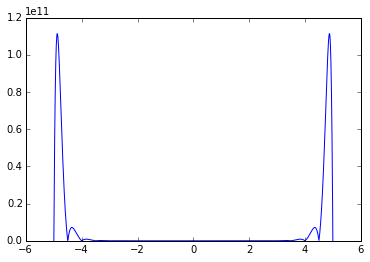

In [134]:
# define w
w = lambda x,q: np.prod( [ x-q[i] for i in range(len(q)) ], axis = 0   )
q = np.linspace(-5,5,n+1)
x = np.linspace(-5,5,2**10+1)
Ln = lagrangian_interpolation_matrix(x,q)

error = l_infty(f(x) - Ln.T.dot(f(q)))

# _ = pl.plot(x,abs(w(x,q)))


If I didn't mess the code this a good spot to play aroud with the function to be checked:

In [ ]:
# Test on one f

In [ ]:
# Make it a python function call